# < 5. Class Activation Map 살펴보기 >

## 학습내용
1. Explainable AI
2. CAM: Class Activation Map
3. Grad-CAM
4. ACoL: Adversarial Complementary Learning
5. 생각해 보기

---

## 5.2 Explainable AI
- 모델이 잘못된 답변을 준다면 어떻게 개선할 수 있을지, 잘 동작한다면 왜 이런 선택을 했는지 알고자 하는 것을 XAI(explainalbe AI)라고 한다.

### 이미지 분류 문제(Image Classification)

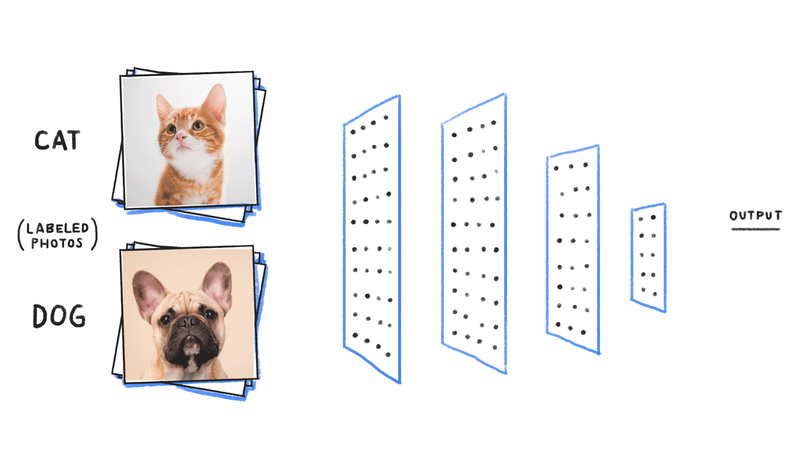

위 그림처럼 분류모델에 이미지가 입력으로 들어온다고 생각해봅시다. 먼저 일반적인 이미지 분류 모델은 이미지의 local feature를 추출하기 위해 CNN으로 구성된 특성 추출용 백본 네트워크(backbone network)가 앞에 있습니다. 백본 네트워크에서 추출된 특성 맵(feature map)을 fully connected layer에 통과시켜 얻어진 logit을 소프트맥스(softmax) 활성화 함수에 통과시키면, 입력 이미지가 각 클래스에 속할 확률을 얻을 수 있습니다.

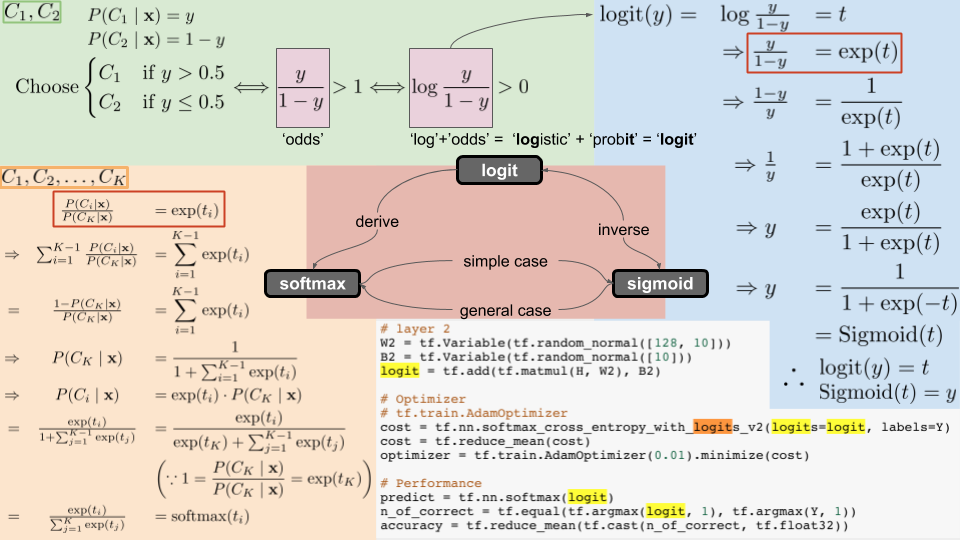
- logit은 sigmoid의 역함수이며, softmax는 sigmoid를 k개의 클래스로 일반화한 것이다

#### 이미지 분류 문제에서 딥러닝 모델이 어떤 클래스로 정답을 냈을 때, 모델 내부에서 그 이유를 찾아볼 수 있는 방법은 어떤 것이 있을까?
- 레이어마다 feature map을 시각화해서, activation이 어떻게 되어있는지 확인해 볼 수 있다


---

## 5.3 CAM: Class Activation Map

### CAM(Class Activation Map)
- 모델이 어떤 곳을 보고 어떤 클래스임을 짐작하고 있는지 확인할 수 있는 지도
- https://arxiv.org/abs/1512.04150

### 1) GAP(Global Average Pooling)

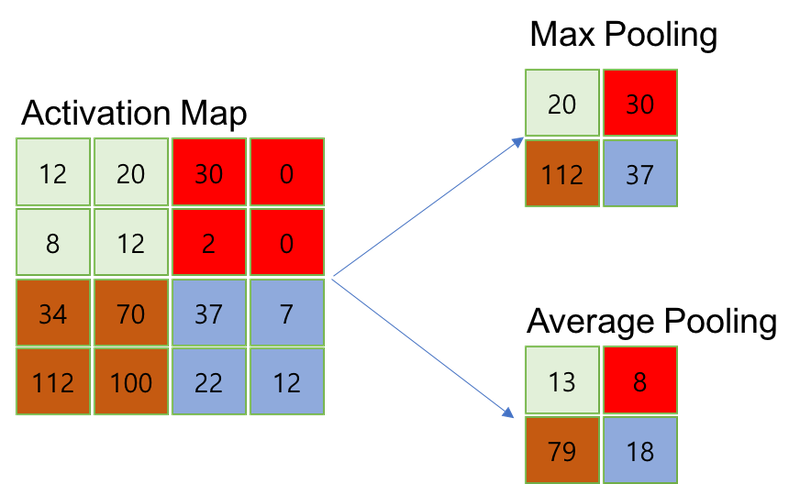

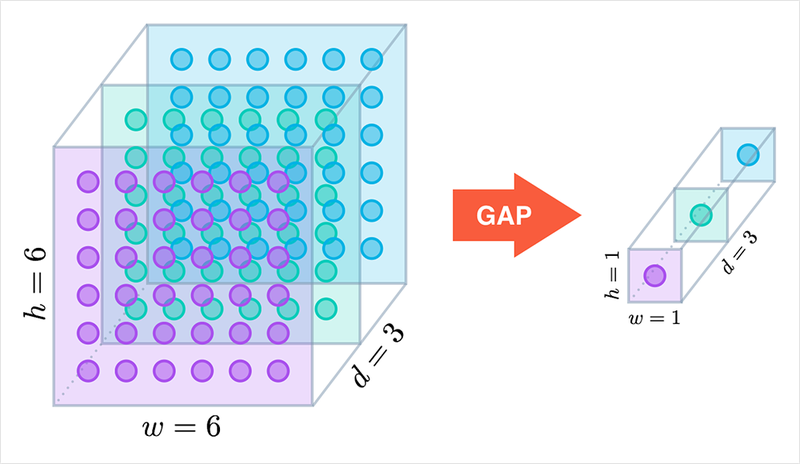

분류 모델의 마지막 부분에서 fully connected layer 대신 GAP을 사용하는 방법은 Network in Network라는 논문에서 제안되었습니다.

일반적으로 이미지 분류에서는 여러 CNN 레이어를 거쳐 우선 특성을 추출하고, 그 특성 맵을 flattening 한 후 fully connected layer에 입력해 줌으로써 각 클래스에 따른 logit을 구하고 최종적으로 활성화 함수를 거치게 합니다.

그러나 Network in Network 논문에서는 CNN 이후 fully connected layer 대신 GAP 연산을 합니다. GAP(Global Average Pooling)은 매 채널별로, average pooling을 채널의 값 전체에 global하게 적용합니다. 위 그림에서 볼 수 있듯이 크기가 6x6이고 채널이 3개인 특성맵에 대해서 GAP을 수행하면 각 채널이 딱 한 개의 숫자로 요약되어, 1x1 크기의 채널이 3개인 벡터를 얻게 됩니다. 이때 결과 벡터의 각 차원의 값은 6x6 크기의 특성 맵을 채널별로 평균을 낸 값입니다.

아래 그림처럼 GAP 연산을 하고, 그 연산 결과에 소프트맥스 활성화 함수를 적용합니다. 이때 마지막 CNN 레이어의 채널 수는 데이터의 클래스 수에 맞춰 각 클래스에 따른 확률을 얻을 수 있도록 했습니다. 원 논문에서는 이렇게 하면 특성 맵의 각 채널이 클래스별 신뢰도를 나타내게 되어 해석이 쉬울 뿐만 아니라, fully connected layer와 달리 최적화할 파라미터가 존재하지 않으므로 과적합(overfitting)을 방지할 수 있다고 설명합니다.

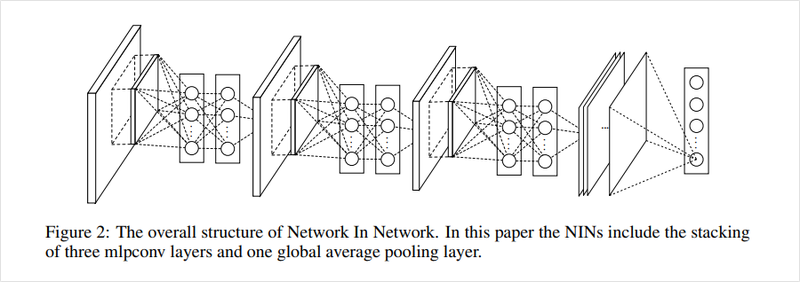



### 2) CAM
- 클래스가 활성화되는 지도
- 일반적인 CNN은 커널 윈도우에 따라서 특성을 추출하므로 CNN레이어를 거친 특성 맵에도 입력값의 위치정보가 유지된다.
- 따라서 특성 맵의 정보를 이미지 검출이나 세그멘테이션 등의 문제를 푸는 데 이용하기도 한다 

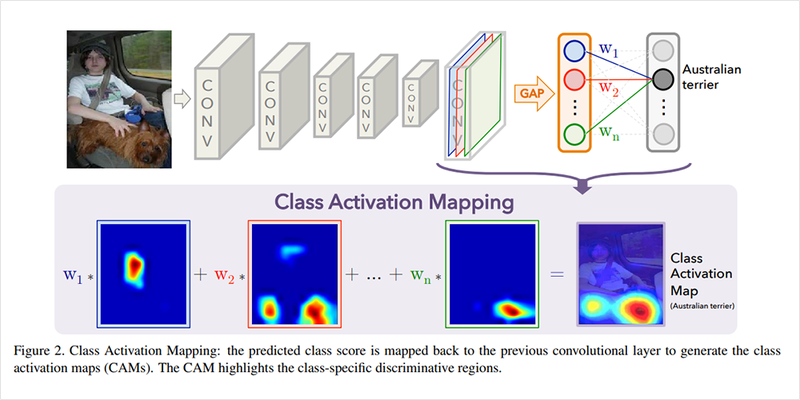

CAM을 얻을 수 있는 네트워크는 위 그림에서 볼 수 있습니다. 먼저 CNN 레이어를 거쳐 뽑아낸 특성 맵에 대해서 GAP을 적용합니다. 그리고 이에 대해서 소프트맥스 레이어(소프트맥스 활성화 함수를 가지고 bias가 없는 fully connected layer)를 적용합니다.

CNN을 거친 특성맵에서 각 클래스에 대한 정보는 결괏값의 여러 채널에 걸쳐 나타나게 됩니다. GAP을 통해 각 채널별 정보를 요약하면 소프트맥스 레이어는 이 정보를 보고 각 클래스에 대한 개별 채널의 중요도를 결정합니다. 이렇게 클래스별로 소프트맥스 레이어를 통해 각 채널의 가중합을 구하면 각 클래스가 활성화 맵의 어떤 부분을 주로 활성화시키는지 확인할 수 있습니다.

이렇게 얻은 특성 맵은 CNN의 출력값 크기와 같게 됩니다. 이를 보간(interpolation)을 통해 적절히 원본 이미지 크기로 확대해 주면 위와 같은 CAM을 얻을 수 있습니다.

---

## 5.4 Grad-CAM

### Grad_CAM
- CAM의 모델 구조가 제한되는 문제를 해결하고, 다양한 모델의 구조를 해석할 수 있는 방법을 제안합니다.
- Grad-CAM을 사용하면 CNN 기반의 네트워크는 굳이 모델 구조를 변경할 필요가 없으며, 분류 문제 외의 다른 태스크들에 유연하게 대처할 수 있습니다.

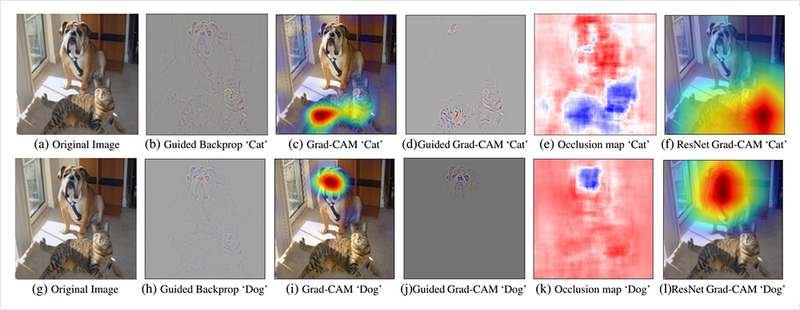

위의 이미지는 개와 고양이가 있는 이미지에 대해서 Guided Backprop, Grad-CAM, Occlussion map의 시각화를 비교하고 있습니다. Grad-CAM에서는 높은 분별력과 큰 dimension을 갖는 CAM을 만드는 것을 중요하게 보았습니다.


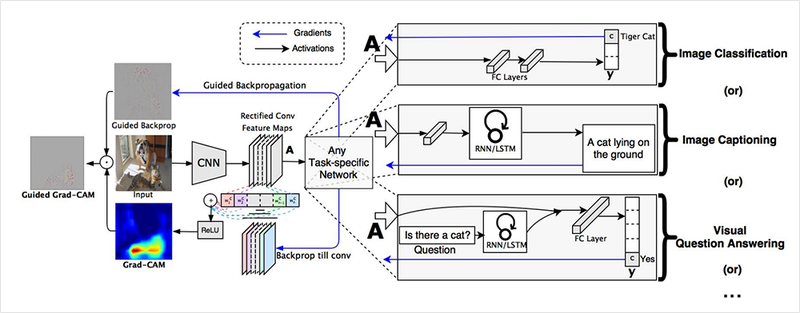

Grad-CAM의 전체적인 구조는 위와 같습니다. 그림의 왼쪽에서 모델의 구조를 볼 수 있습니다. 위에서 보았던 이미지를 입력으로 CNN을 거쳐 특성 맵을 추출하고 그 뒤로 태스크에 따라서 다양한 레이어들이 사용됩니다.

오른쪽의 "Image Classification"과 "Image captioning", "Visual question Answering"은 Grad-CAM이 적용될 수 있는 다양한 컴퓨터 비전 문제들을 설명합니다. Image Classification은 익히 들어오셨겠지만 Image Captioning이나 Visual Question answering은 생소하실 텐데요, Image Captioning은 이미지에 대한 설명을 만들어내는 태스크입니다. Visual question answering은 VQA라고도 불리며, 어떤 질문과 이미지가 주어졌을 때 이에 대한 답변을 내는 태스크입니다.




### 그래디언트를 통한 Weight Score 계산

CAM에서는 소프트맥스를 가진 fully connected layer의 가중치를 통해서 어떤 클래스에 대한 각 채널의 중요도 또는 가중치를 얻어냈습니다. 그렇다면 Grad-CAM에서는 어떻게 CAM을 얻어 낼 수 있을까요? 이름에서 볼 수 있듯, 그래디언트(gradient)를 사용합니다. 원하는 클래스에 대해서 관찰하는 레이어로 들어오는 그래디언트를 구할 수 있다면, 해당 클래스를 활성화할 때, 레이어의 특성 맵에서 어떤 채널이 중요하게 작용하는지 알 수 있습니다.

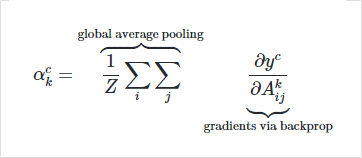

이제 위의 식을 통해서 k 개의 채널을 가진 활성화 맵에서 각 채널이 어떤 클래스를 활성화하는 데 얼마나 중요하게 작용하는지 가중치 점수를 구할 수 있습니다. 이 가중치를 구하기 위해 CAM처럼 별도의 weight 파라미터를 도입할 필요가 없다는 것을 알 수 있습니다.

그러면 이 정보를 합쳐 활성화 맵에서 어떤 클래스의 위치에 따른 활성화를 보려면 어떻게 해야할까요? Grad-CAM은 이를 위해서 k번째 활성화 맵과 이 가중치를 곱해주어 합한 뒤 ReLU 활성화 함수를 통해서 클래스에 따른 Grad-CAM을 얻습니다. 이 수식을 시각화한 것이 맨 위에서 소개한 고양이와 개에 대한 Grad-CAM의 (c), (i)번째 예시입니다.

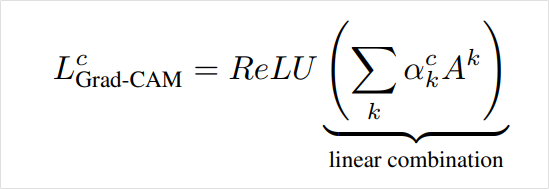


---

## 5.5 ACoL: Adversarial Complementary Learning
CAM에서 신기한 점은 클래스와 이미지만을 데이터로 학습을 하는데 덤으로 위치 정보까지 얻을 수 있다는 것입니다. 이처럼 직접적으로 정답 위치 정보를 주지 않아도 간접적인 정보를 활용하여 학습하고 원하는 정보를 얻어낼 수 있도록 모델을 학습하는 방식을 `약지도학습(weakly supervised learning)` 이라고 합니다. 지금까지 봐왔던 CAM, Grad-CAM 그리고 지금 설명해 드리는 ACoL은 약지도학습 기법을 활용해 물체 검출(object detection)을 수행할 수 있습니다.

### 1) 약지도학습(weakly supervised learning)

#### incomplete supervision 
- 학습 데이터 중 일부에만 라벨이 달린 경우. 일반적으로 말하는 준지도학습과 같은 경우임. (예: 개와 고양이 분류 학습 시 10,000개의 이미지 중 1,000개만 라벨이 있는 경우)

#### inexact supervision 
- 학습데이터의 라벨이 충분히 정확하게 달려있지 않은 경우. (예: 개나 고양이를 Object Detection 또는 Semantic Segmentation해야 하지만 이미지 내에 정확한 bounding box는 주어져 있지 않고 이미지가 개인지 고양인지 정보만 라벨로 달려있는 경우)

#### inaccurate supervision 
- 학습 데이터에 Noise가 있는 경우, (예: 개나 고양이의 라벨이 잘못 달린 경우)


약지도학습이란 위 3가지 경우를 포괄적으로 일컫도록 사용되곤 하지만, 오늘 우리가 다루고자 하는 것은 바로 inexact supervision에 해당하는 경우입니다. 일반적으로 Image Classification용 학습데이터보다는 bounding box 정보까지 정확하게 포함해야 하는 Object Detection이나 Semantic Segmentation을 위한 학습데이터가 훨씬 제작비용이 많이 듭니다.

아래는 Grad-CAM 논문에서 언급한 약지도학습을 통한 Object Detection과 Semantic Segmentation의 예시입니다.
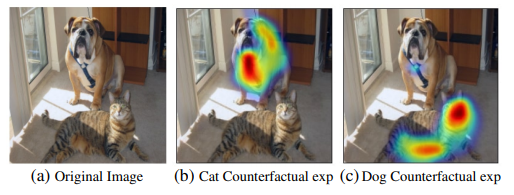

위 사진은 Grad-CAM을 통한 Counterfactual Explanation 예시입니다. 아이디어는 간단합니다. Grad-CAM을 통해서는 개와 고양이의 특징이 두드러지게 하는 영역의 가중치 점수를 계산할 수 있었지만, 해당 가중치 점수를 제거해 주면 Image classification 모델에서 해당 클래스에 대한 prediction이 바뀌게 될 수도 있습니다. 가중치 점수를 제거했을 때 prediction이 바뀌도록 하는 가중치 영역을 모으면 bounding box 라벨을 한 번도 보지 않고서도 object detection을 해낼 수 있다는 것입니다.
또 다른 예로, 네이버랩스에서는 자율주행 연구에 약지도학습을 활용한 예를 확인할 수 있습니다


### 2) Adversarial Complementary Learning

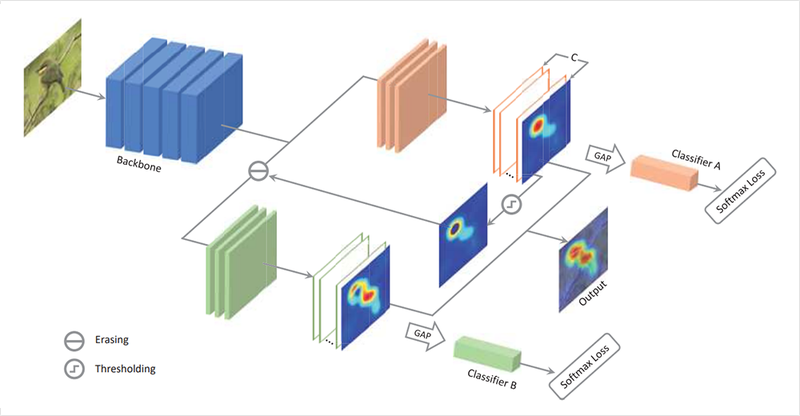

Adversarial의 뜻은 "적대적인"입니다. 그렇다면 논문 제목에서 사용된 Adversarial Complementary Learning (ACoL)은 어떤 방법일까요? 위 그림에서 볼 수 있듯이 ACoL은 모델의 학습에는 끝단이 두 브랜치(branch)로 나뉩니다. CAM을 만들기 위해 활용했던 특성 맵을 두 가지로 분리한 것입니다.

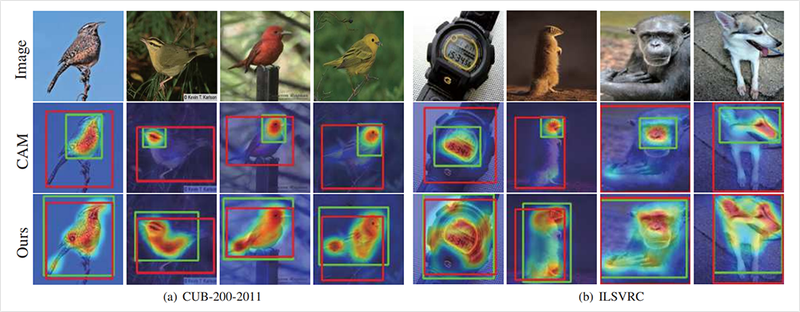

CAM과 Grad-CAM은 Weaky-supervised 방식의 Object Detection, Segmentation의 가능성을 보여 주었습니다. 그러나 이들 방식에는 한 가지 문제가 있습니다. CAM을 통해 본 활성화 맵을 보면 가장자리보다는 특징이 주로 나타나는 위치에 중점적으로 활성화되는 모습을 볼 수 있습니다.

하지만 물체 검출(Object detection)은 새의 부리나 동물의 눈, 시계의 숫자와 같이 부분적 특성이 아닌 물체의 전체적인 형태와 윤곽을 정확하게 구분해 내는 것이 중요합니다. CAM 모델이 특정 부위에 집중해 학습하는 것을 막기 위해서 ACoL은 브랜치를 두 가지로 두어 너무 높은 점수를 지워줌으로써 주변의 특성 또한 반영하도록 했습니다. 이러한 과정을 논문에서는 Adversial, 즉 적대적인 학습방법이라고 합니다.

ACoL의 구조를 살펴보면 먼저 위쪽 주황색 브랜치를 거칩니다. 특성 맵은 GAP을 거쳐 CAM에서 보았던 소프트맥스 레이어인 Classifier A를 거치게 됩니다. 이 브랜치는 loss로 학습됩니다.

ACoL은 여기서 얻어진 활성화 맵을 적대적인 방법으로 사용합니다. 일정 값 이상 활성화된 활성화 맵을 지우도록 하는 것이지요. Classifier A는 쉽게 전체적인 이미지를 보고 클래스를 판별할 수 있는 반면에 Classifier B는 A의 CAM에서 크게 활성화된 영역을 지운 활성화 맵에서 분류를 해야 하기 때문에 더 어려운 문제를 푸는 것으로 볼 수 있습니다.

이렇게 두 가지 Classifier A와 Classifier B를 학습시킴으로써 더 넓은 영역을 판별의 근거로 삼을 수 있습니다. 이 과정을 통해서 모델은 쉽게 맞출 수 있는 샘플을 어렵게 다시 한 번 학습을 하는 Adversarial Complementary Learning 과정을 거치게 됩니다.